In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [2]:
# Create Session for our Work
spark = SparkSession.builder.appName('Smart Grid Classification').getOrCreate()

In [3]:
# load the dataset and create sprk dataframe
df = spark.read.csv('C://Users//yassi//Data_Smart_Grid_Stability.csv',inferSchema=True,header=True)
# Using limit(), or select() or show() to view the data. I often use limit()
# Using toPandas() method to return Pyspark DataFrame as Pandas table
df.limit(3).toPandas()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable


In [4]:
df.printSchema()

root
 |-- tau1: double (nullable = true)
 |-- tau2: double (nullable = true)
 |-- tau3: double (nullable = true)
 |-- tau4: double (nullable = true)
 |-- p1: double (nullable = true)
 |-- p2: double (nullable = true)
 |-- p3: double (nullable = true)
 |-- p4: double (nullable = true)
 |-- g1: double (nullable = true)
 |-- g2: double (nullable = true)
 |-- g3: double (nullable = true)
 |-- g4: double (nullable = true)
 |-- stab: double (nullable = true)
 |-- stabf: string (nullable = true)



## Visualisation

In [5]:
all_data = pd.read_csv('C:/Users/yassi/Data_Smart_Grid_Stability.csv')
all_data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [6]:
all_data = pd.get_dummies(all_data, columns = ['stabf'], drop_first = True)

In [7]:
all_data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf_unstable
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1


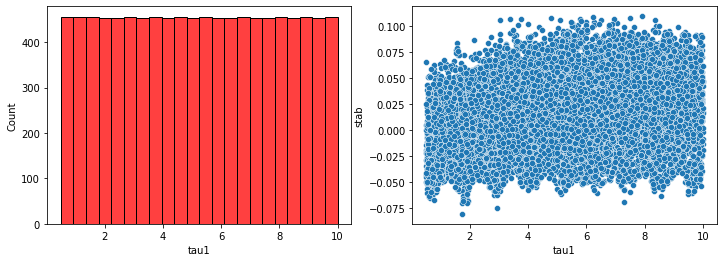

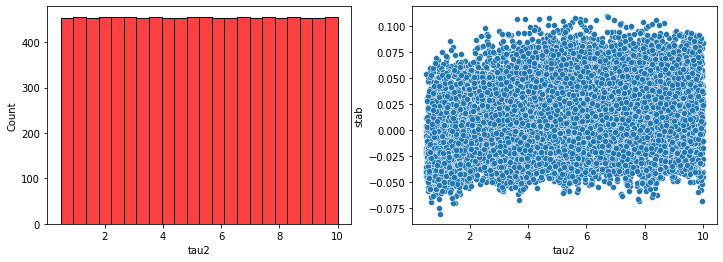

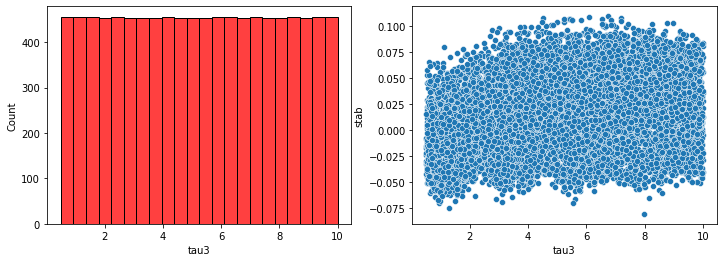

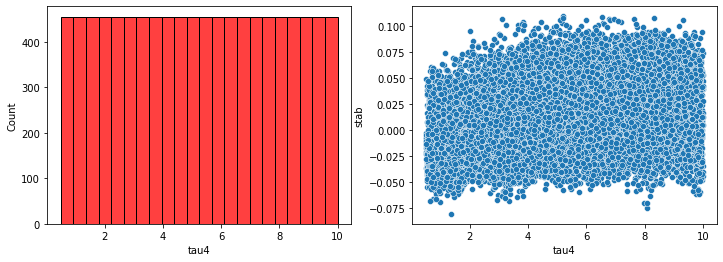

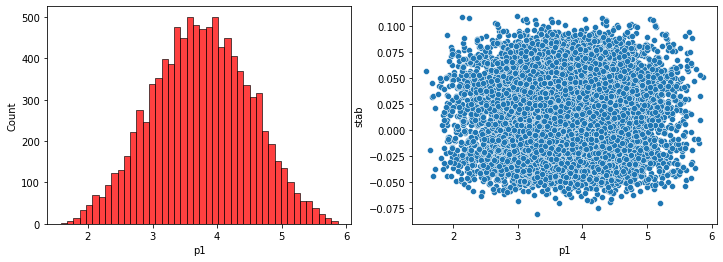

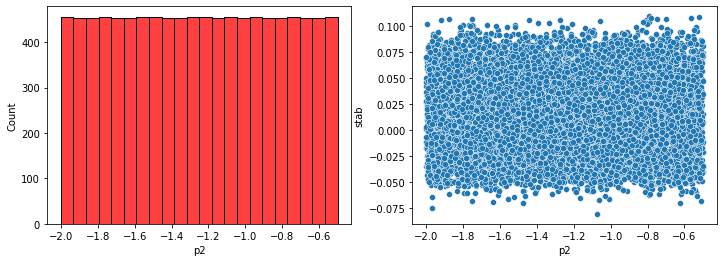

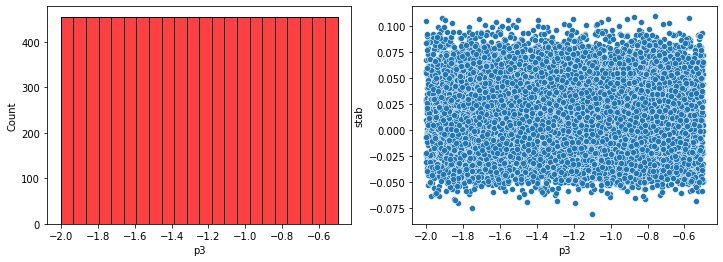

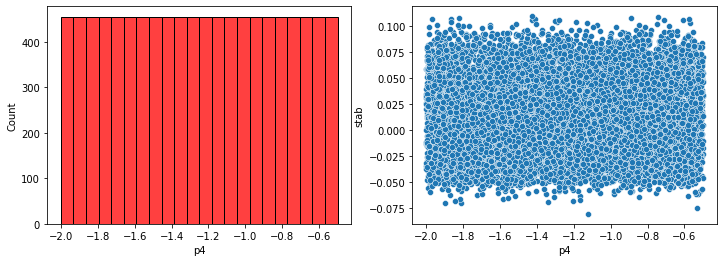

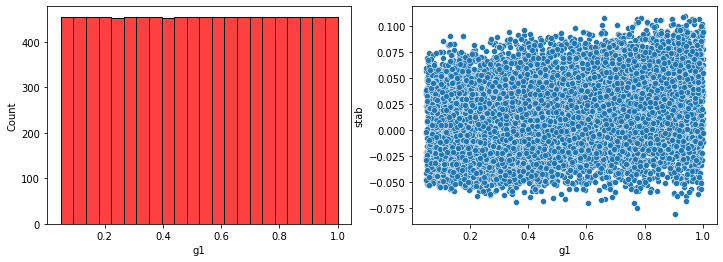

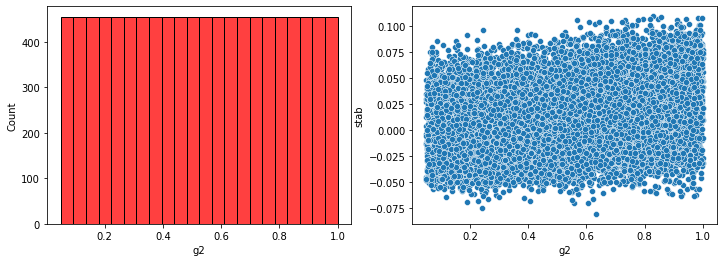

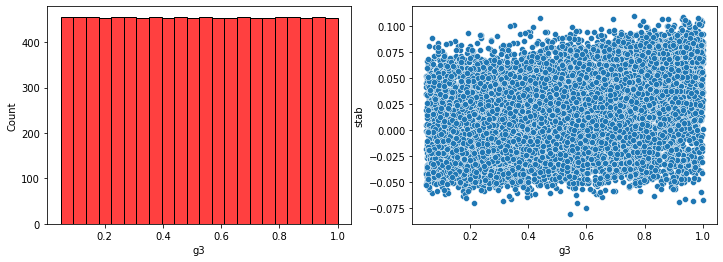

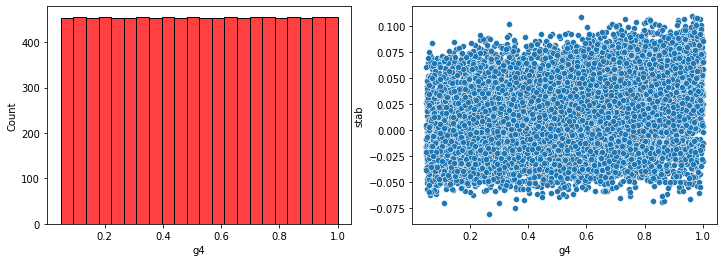

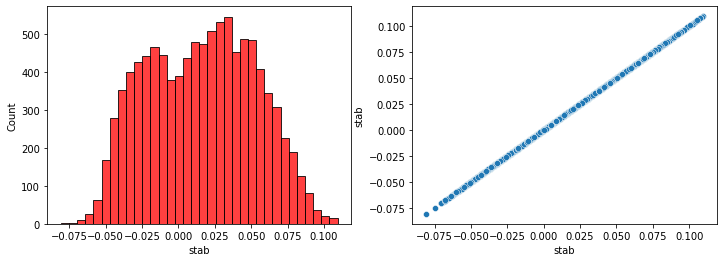

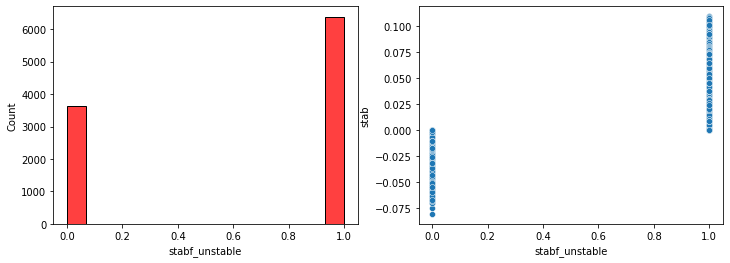

In [8]:
for column in all_data:
    plot_fig, plot_axes = plt.subplots(1, 2, figsize = (12, 4))
    chart_1 = sns.histplot(x=(all_data[column]), ax = plot_axes[0], color='r')
    
    chart_2 = sns.scatterplot(x = column, y = 'stab', data = all_data, ax = plot_axes[1])

    plt.show()
del plot_fig, plot_axes

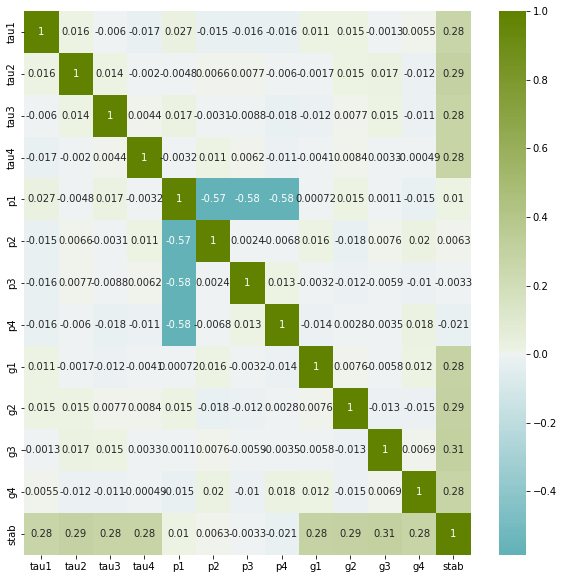

In [9]:
# Correlation matrix helps us to identify features that are more important then the others.
corr_data = all_data.corr()
fig, ax = plt.subplots(figsize = (10, 10))
color_map = sns.diverging_palette(204, 106, s = 100, as_cmap=True)
sns.heatmap(corr_data.drop(columns=['stabf_unstable'], index=['stabf_unstable']), cmap=color_map, annot=True, ax = ax, center=0.00000)
plt.show()
del corr_data

## Pretraitement

In [10]:
data = df.withColumn('stability', when(df.stab > 0, 0).otherwise(1))

In [11]:
data = data.drop('stabf')
data.limit(6).toPandas()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stability
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0
5,6.999209,9.109247,3.784066,4.267788,4.429669,-1.857139,-0.670397,-1.902133,0.261793,0.077930,0.542884,0.469931,-0.017385,1


In [12]:
data = data.drop('stab')
data.limit(5).toPandas()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stability
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0


In [13]:
data.groupBy("stability").count().show()


+---------+-----+
|stability|count|
+---------+-----+
|        1| 3620|
|        0| 6380|
+---------+-----+



In [14]:
numeric_features = [t[0] for t in data.dtypes if t[1] == 'double' or t[1] == 'int']
data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
tau1,10000,5.249999930614209,2.7425483741341647,0.500793021360319,9.99946946943287
tau2,10000,5.250001022042511,2.7425486737170175,0.500141360493773,9.99983655621537
tau3,10000,5.2500035241544225,2.7425494575854055,0.500788152733829,9.99945000849598
tau4,10000,5.249997064361223,2.7425555299775657,0.500472961226082,9.99944329731088
p1,10000,3.7499999579361503,0.7521601049043652,1.58258966481528,5.8644179596283
p2,10000,-1.2500004574399335,0.43303484993229047,-1.99989095591106,-0.500108275885764
p3,10000,-1.249999744447177,0.4330350963379907,-1.99994466917731,-0.50007225154374
p4,10000,-1.2499997560490506,0.43303499416424773,-1.99992633173043,-0.500024528740323
g1,10000,0.5249997888492062,0.27425553195105695,0.0500093036111293,0.999937073063054


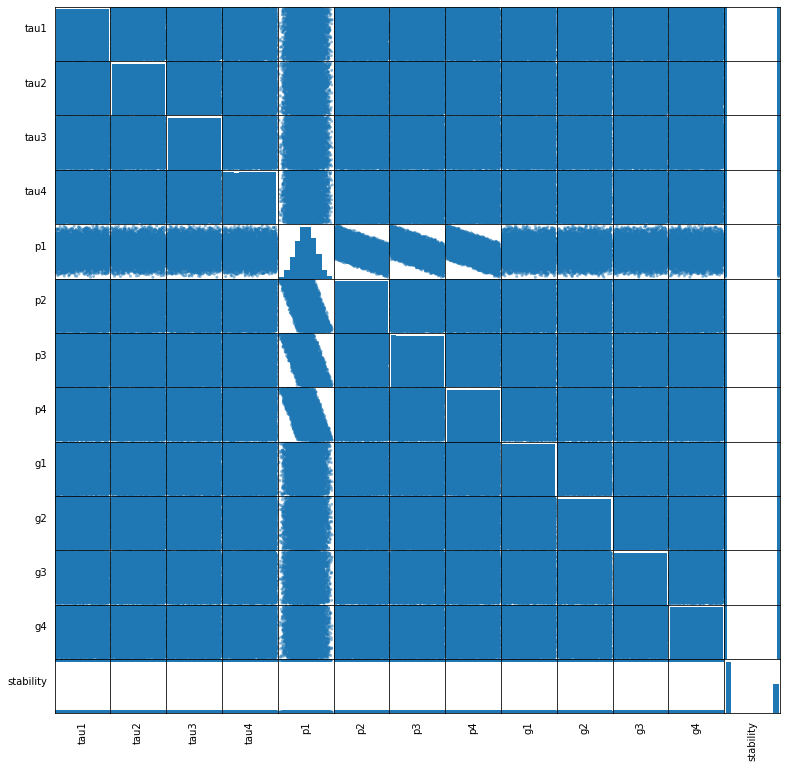

In [15]:
from pandas.plotting import scatter_matrix
numeric_data = data.select(numeric_features).toPandas()
axs = scatter_matrix(numeric_data, figsize=(13, 13));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [16]:
from pyspark.ml.linalg import Vectors

assembler = VectorAssembler(
    inputCols=["tau1", "tau2", "tau3", "tau4", "p1", "p2", "p3", "p4", "g1", "g2", "g3", "g4"],
    outputCol="features")

data = assembler.transform(data)

In [17]:
data.limit(3).toPandas()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stability,features
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0,"[2.95906002455997, 3.07988520422811, 8.3810253..."
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1,"[9.3040972346785, 4.90252411201167, 3.04754072..."
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0,"[8.97170690932022, 8.84842842134833, 3.0464787..."


In [18]:
# Split the dataset to train_df and test_df
train_df,test_df = data.randomSplit([0.75,0.25])
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 7493
Test Dataset Count: 2507


## LogisticRegression

In [19]:
# LOAD PYSPARK LIBRARIES
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from sklearn.metrics import roc_curve,auc

# DEFINE ALGORITHM 
lr = LogisticRegression(labelCol="stability")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.01))\
                              .addGrid(lr.maxIter, (20, 60))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()
# DEFINE CROSS VALIDATION WITH PARAMETERS
evaluator=MulticlassClassificationEvaluator(labelCol='stability')
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=evaluator
                           ,trainRatio=0.5)
model = tvs.fit(train_df)
model_predictions = model.transform(test_df)

In [20]:
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='stability',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='stability',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8141204627044276
Precision:  0.8114065867874278


In [21]:
model_predictions.select("stability","prediction").show(20)

+---------+----------+
|stability|prediction|
+---------+----------+
|        1|       1.0|
|        0|       0.0|
|        0|       0.0|
|        1|       1.0|
|        1|       1.0|
|        1|       0.0|
|        1|       1.0|
|        0|       0.0|
|        1|       1.0|
|        0|       1.0|
|        0|       0.0|
|        0|       0.0|
|        1|       1.0|
|        1|       1.0|
|        0|       1.0|
|        0|       0.0|
|        1|       1.0|
|        0|       0.0|
|        1|       0.0|
|        0|       0.0|
+---------+----------+
only showing top 20 rows



## Evaluating ROC metric

In [22]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
results = model_predictions.select(['probability', 'stability'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = spark.sparkContext.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

C:\Users\yassi\anaconda3\envs\myEnv_3_9\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  0.8873513802122077


## Visualizing AUC metrics

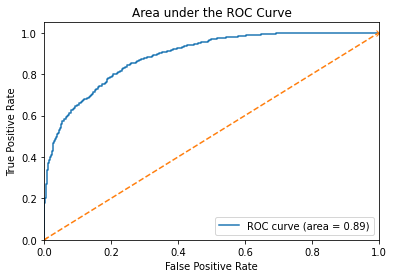

In [23]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'x--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [24]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

Random_Forest = RandomForestClassifier(labelCol='stability')
paramGrid = ParamGridBuilder()\
                                .addGrid(Random_Forest.maxDepth, [5, 10, 20]) \
                                .addGrid(Random_Forest.maxBins, [20, 32, 50]) \
                                .addGrid(Random_Forest.numTrees, [20, 40, 60 ]) \
                                .addGrid(Random_Forest.impurity, ["gini", "entropy"]) \
                                .addGrid(Random_Forest.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit( estimator=Random_Forest
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='stability')
                           ,trainRatio=0.8)
model_RF = tvs.fit(train_df)
model_predictions_RF= model_RF.transform(test_df)


In [25]:
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='stability',metricName='accuracy').evaluate(model_predictions_RF))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='stability',metricName='weightedPrecision').evaluate(model_predictions_RF))

Accuracy:  0.9146390107698444
Precision:  0.9143977481466129


In [26]:
model_predictions_RF.select("stability","prediction").show(10)

+---------+----------+
|stability|prediction|
+---------+----------+
|        1|       1.0|
|        0|       0.0|
|        0|       0.0|
|        1|       1.0|
|        1|       1.0|
|        1|       0.0|
|        1|       1.0|
|        0|       0.0|
|        1|       1.0|
|        0|       0.0|
+---------+----------+
only showing top 10 rows



In [27]:
results = model_predictions_RF.select(['probability', 'stability'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = spark.sparkContext.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

C:\Users\yassi\anaconda3\envs\myEnv_3_9\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  0.9764804971072064


## Visualizing AUC metrics

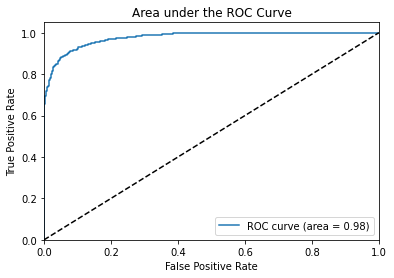

In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()